# 회귀 - 자전거 대여 수요 예측


Kaggle의 "Bike Sharing Demand" 대회 데이터를 기반으로 자전거 대여 수요를 예측하는 회귀 분석을 수행한다.

학습 데이터에는 2011년부터 2012년까지의 날짜/시간별 자전거 대여 수요 정보가 포함되어 있으며,  
예측 성능 평가는 RMSLE (Root Mean Squared Logarithmic Error) 지표를 기준으로 수행된다

<br>

1. 데이터 로드 및 확인
    
    1.1 &nbsp;라이브러리 및 데이터 불러오기  
    1.2 &nbsp;데이터 확인  
    1.3 &nbsp;타겟 데이터 확인  
    1.4 &nbsp;결측치 및 이상치 확인  
    
2. 데이터 전처리 로그 변환
    
    2.1 &nbsp;로그 변환  
    2.2 &nbsp;One-Hot Encoding  
    2.3 &nbsp;Train/Test 데이터 분리  

3. 모델 학습 및 평가 함수 정의
    
    3.1 &nbsp;회귀 모델 성능 평가 함수  
    3.2 &nbsp;회귀 모델 학습 및 평가 함수  
    3.3 &nbsp;개별 모델 실행 함수  

4. 모델 비교 및 선택
    
    4.1 &nbsp;LinearRegression  
    4.2 &nbsp;Ridge  
    4.3 &nbsp;Lasso  
    4.4 &nbsp;RandomForest  
    4.5 &nbsp;XGBoost  
    4.6 &nbsp;LightGBM  
    4.7 &nbsp;Baseline 모델 성능 비교  
    
5. 하이퍼파라미터 튜닝
    
    5.1 &nbsp;GridSearch: LightGBM  
    5.2 &nbsp;GridSearch: XGBoost  
    5.3 &nbsp;RandomSearch: LightGBM  
    5.4 &nbsp;RandomSearch: XGBoost  

4. Fine-tuning

    6.1 &nbsp;LightGBM  
    6.2 &nbsp;XGBoost  
    
6. Submission


<br>

## 1. 데이터 로드 및 확인


### 1.1 &nbsp;라이브러리 및 데이터 불러오기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import warnings
# warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv('/content/drive/MyDrive/DS/ML/train_bike.csv')
test = pd.read_csv('/content/drive/MyDrive/DS/ML/test_bike.csv')

<br>

### 1.2 &nbsp;데이터 확인

해당 데이터 셋에는 2011년 1월부터 2012년 12월까지 날싸/시간, 기온, 습도, 풍속 드으이 정보를 기반으로 1시간 간격 동안의 자전거 대여 횟수가 담겨 있다.

- 컬럼: 설명



타겟값은 대여 횟수인 count이다.

In [4]:
print(train.shape)
train.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [5]:
print(test.shape)
test.head(3)

(6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000


In [6]:
# 전체 데이터에서 학습 데이터의 비율 확인
print(len(train), len(test))
len(train)/(len(train) + len(test))

10886 6493


0.6263881696300132

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


<br>

### 1.3 &nbsp; 타겟 데이터 확인

In [8]:
# count 분포 확인
train['count'].value_counts(normalize=True)*100

,proportion
count,
5,1.552453
4,1.368730
3,1.322800
6,1.240125
2,1.212567
...,...
842,0.009186
683,0.009186
863,0.009186


<br>

### 1.4 &nbsp;결측치 및 이상치 확인

In [9]:
# 결측치 확인
train.isnull().sum().sum()

np.int64(0)

In [10]:
# 중복값 확인
train[train.duplicated() == 1]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count


<br>

## 2. 데이터 전처리

In [11]:
# 문자열을 datetime 타입으로 변경
train['datetime'] = train.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
train['year'] = train.datetime.apply(lambda x : x.year)
train['month'] = train.datetime.apply(lambda x : x.month)
train['day'] = train.datetime.apply(lambda x : x.day)
train['hour'] = train.datetime.apply(lambda x: x.hour)
train.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [12]:
drop_columns = ['datetime', 'casual', 'registered']
train.drop(drop_columns, axis=1,inplace=True)

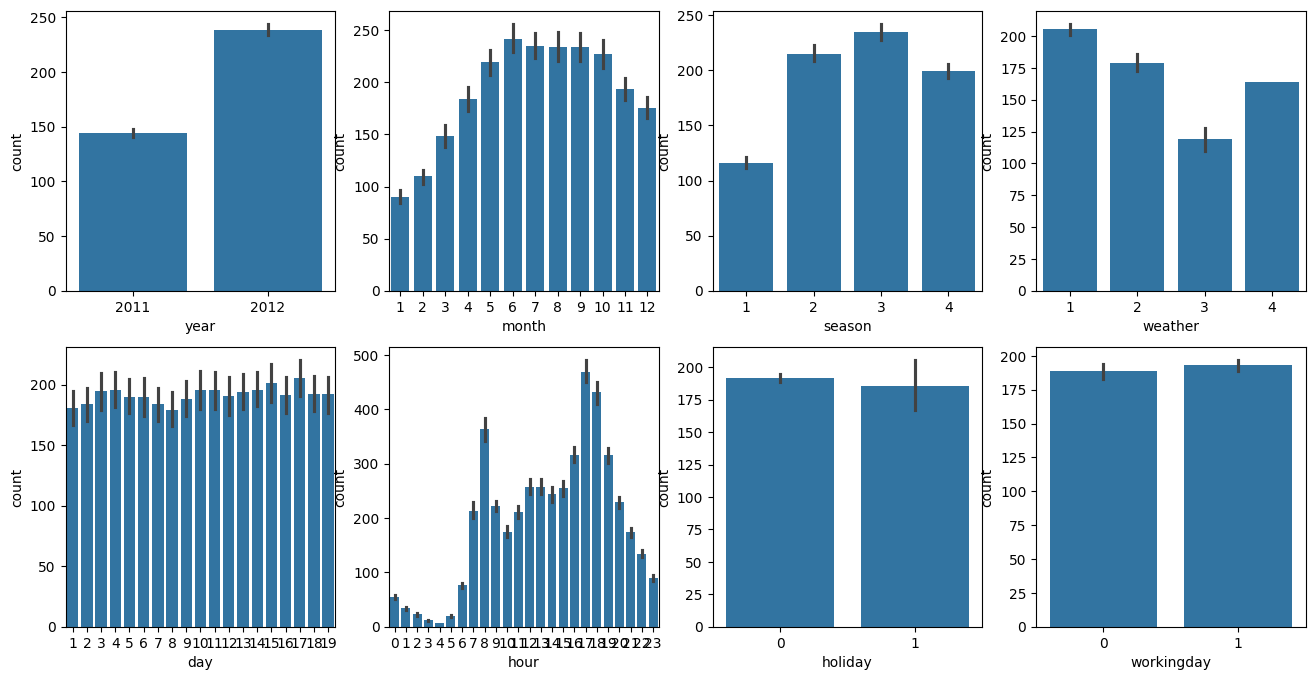

In [13]:
fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)
cat_features = ['year', 'month','season','weather','day', 'hour', 'holiday','workingday']

# cat_features에 있는 모든 칼럼별로 개별 칼럼값에 따른 count의 합을 barplot으로 시각화
for i, feature in enumerate(cat_features):
    row = int(i/4)
    col = i%4
    # 시본의 barplot을 이용해 칼럼값에 따른 count의 합을 표현
    sns.barplot(x=feature, y='count', data=train, ax=axs[row][col])

<br>

### 2.1 &nbsp;로그 변환

- 타겟 피처는 count는 대여 수치로, 대부분의 값이 낮은 수치에 몰려 있고 일부 값만 매우 큰 우측 편향(Right Skewed) 분포를 보인다.

- 극단적인 이상치(outlier)가 많고 정규성이 떨어지므로 모델이 이를 기준으로 학습하게 되면 예측이 왜곡될 수 있다.


데이터를 정규분포에 가깝게 만들고, 이상치를 로그 변환으로 눌러 모델 안정성과 예측 정확도를 높이기 위해 로그 변환을 수행한다. 특히 MSE 기반 회귀에서는 큰 오차에 민감하므로 로그로 줄여주면 모델이 작은 수치도 잘 학습할 수 있게 된다.

In [14]:
y_target = train['count']  # 타겟 지정
X_features = train.drop(['count'],axis=1,inplace=False)  # 타겟 컬럼 제거

In [15]:
# 로그 변환
y_target_log = np.log1p(y_target)

<br>

로그 변환 후 로그 스케일에서 타깃값의 분포를 확인해 본다.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=42)

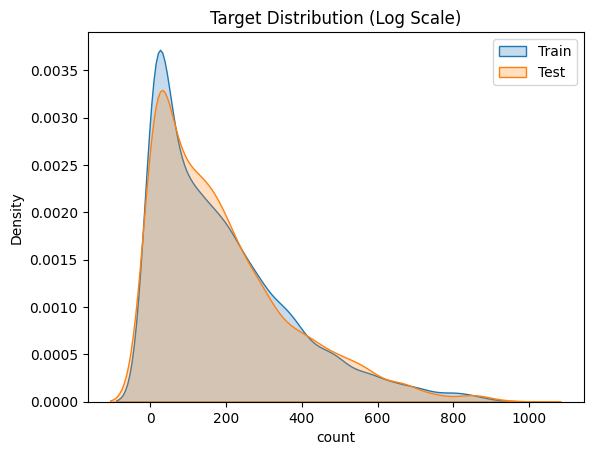

In [17]:
sns.kdeplot(y_train, label='Train', fill=True)
sns.kdeplot(y_test, label='Test', fill=True)
plt.legend()
plt.title('Target Distribution (Log Scale)')
plt.show()

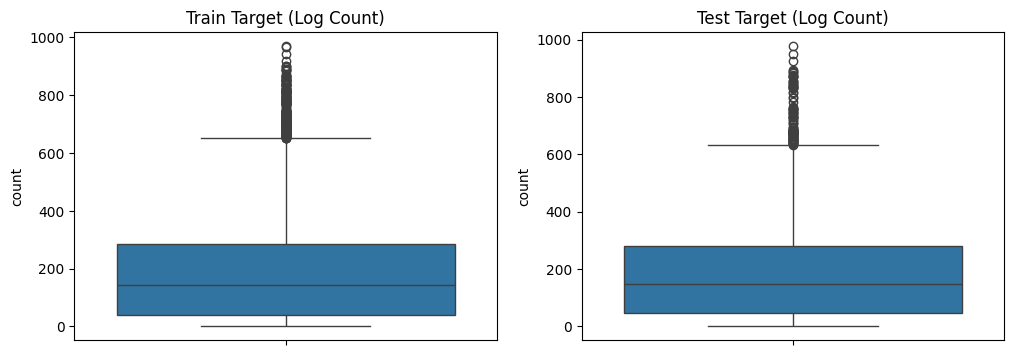

In [18]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.boxplot(y_train)
plt.title('Train Target (Log Count)')

plt.subplot(1, 2, 2)
sns.boxplot(y_test)
plt.title('Test Target (Log Count)')
plt.show()

KDE Plot
- 두 분포는 거의 유사하나 전체적으로 오른쪽으로 긴 꼬리를 가짐
- 로그 변환에도 불구하고 여전히 완전한 정규성은 아님

Boxplot
- 이상치가 다수 존재
- 중앙값 기준 분포는 안정적이지만 위쪽으로 뻗은 값들이 많음


로그 변환으로 전체 분포는 완화되었지만 여전히 타깃값이 시간대(hour), 요일, 날씨 등의 영향을 반영하지 못한 상태이다. 모델은 이런 영향을 반영할 수 없으므로 성능 저하 가능성 있으므로 원-핫 인코딩을 수행한다.

<br>

### 2.2 &nbsp;One-hot Encoding

One-Hot Encoding을 통해 Train/Test 간 타겟 분포가 더 정규 분포에 가까워지고, 이상치 영향도 감소하여
전체적으로 모델 학습에 적합한 분포 형성을 기대한다.

In [19]:
# 'year', month', 'day', hour'등의 피처들을 One Hot Encoding

# 없는 day까지 encoding
X_features['day'] = pd.Categorical(X_features['day'], categories=range(1, 31))


X_features_ohe = pd.get_dummies(X_features,
                                columns=['year', 'month','day', 'hour', 'holiday',
                                              'workingday','season','weather'])

In [20]:
X_features_ohe

,temp,atemp,humidity,windspeed,year_2011,year_2012,month_1,month_2,month_3,month_4,...,workingday_0,workingday_1,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,9.84,14.395,81,0.0000,True,False,True,False,False,False,...,True,False,True,False,False,False,True,False,False,False
1,9.02,13.635,80,0.0000,True,False,True,False,False,False,...,True,False,True,False,False,False,True,False,False,False
2,9.02,13.635,80,0.0000,True,False,True,False,False,False,...,True,False,True,False,False,False,True,False,False,False
3,9.84,14.395,75,0.0000,True,False,True,False,False,False,...,True,False,True,False,False,False,True,False,False,False
4,9.84,14.395,75,0.0000,True,False,True,False,False,False,...,True,False,True,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,15.58,19.695,50,26.0027,False,True,False,False,False,False,...,False,True,False,False,False,True,True,False,False,False
10882,14.76,17.425,57,15.0013,False,True,False,False,False,False,...,False,True,False,False,False,True,True,False,False,False
10883,13.94,15.910,61,15.0013,False,True,False,False,False,False,...,False,True,False,False,False,True,True,False,False,False
10884,13.94,17.425,61,6.0032,False,True,False,False,False,False,...,False,True,False,False,False,True,True,False,False,False


<br>

### 2.3 &nbsp;Train/Test 데이터 분리

In [21]:
# 4. train/test 분리
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size=0.3, random_state=42)

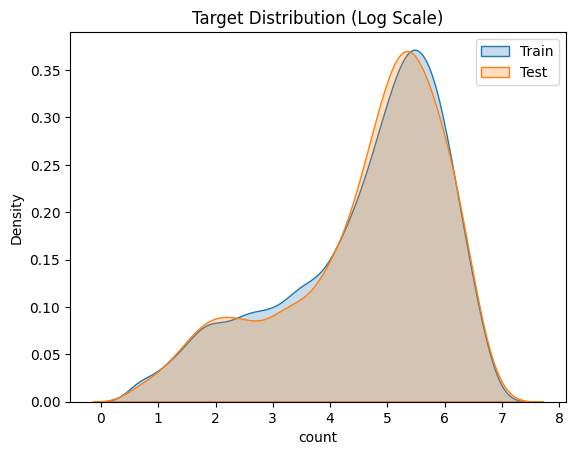

In [22]:
sns.kdeplot(y_train, label='Train', fill=True)
sns.kdeplot(y_test, label='Test', fill=True)
plt.legend()
plt.title('Target Distribution (Log Scale)')
plt.show()

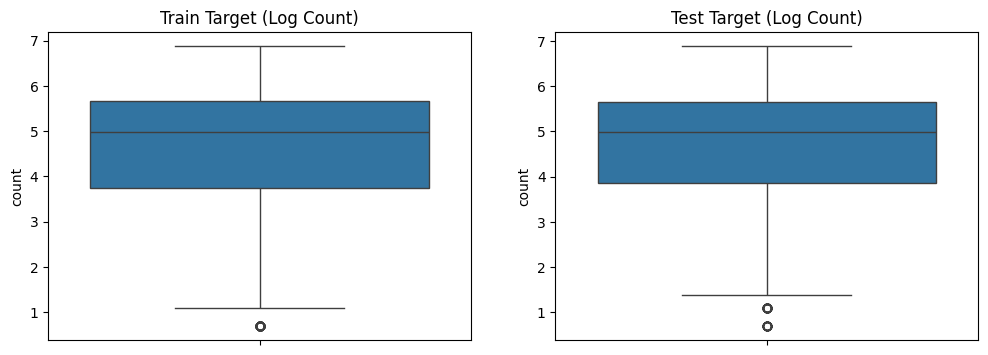

In [23]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.boxplot(y_train)
plt.title('Train Target (Log Count)')

plt.subplot(1, 2, 2)
sns.boxplot(y_test)
plt.title('Test Target (Log Count)')
plt.show()

KDE
- 분산이 줄고 Train/Test 간 분포 차이 거의 없음
- 분포 형태는 더 좌우 대칭에 가깝고 이사잋 없이 안정적
- 선형 모델이나 RMSLE 기반 모델 학습에 적합한 상태로 보임

Boxplot
- 이상치는 여전히 존재하지만 사분위 범위(IQR)가 좁아짐
- 전체 분포가 더 집중된 형태로 안정화됨


로그 변환만으로는 타깃값 분포의 왜곡을 완전히 해소할 수 없으며, 범주형 변수들의 영향력 또한 반영되지 않는다.

One-Hot Encoding을 통해 범주형 변수들을 명시적으로 분리한 후 모델에 입력하면 각 카테고리에 따른 타깃값의 영향력을 모델이 개별적으로 학습할 수 있다.

<br>
<br>

## 3. 모델 학습 및 평가 함수 정의

### 3.1 &nbsp;회귀 모델 성능 평가 함수

- 회귀 성능 지표 함수

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# RMSLE 계산 함수
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    return np.sqrt(np.mean((log_y - log_pred) ** 2))


# RMSE 계산 함수
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

# 통합 평가 출력 함수
def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    mae_val = mean_absolute_error(y, pred)
    print(f'RMSLE: {rmsle_val:.3f}, RMSE: {rmse_val:.3f}, MAE: {mae_val:.3f}')
    return rmsle_val, rmse_val, mae_val

<br>

- 예측 오차 분석 함수

In [25]:
def get_top_error_data(y_test, pred, n_tops = 5):
    # DataFrame에 컬럼들로 실제 대여횟수(count)와 예측 값을 서로 비교 할 수 있도록 생성.
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']= np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    # 예측값과 실제값이 가장 큰 데이터 순으로 출력.
    print(result_df.sort_values('diff', ascending=False)[:n_tops])

<br>

- Feature Importance 시각화 함수 (Linear 계열만)


In [26]:
def plot_feature_importance(model, feature_names, top_n=20):
    if hasattr(model, 'coef_'):
        coef = pd.Series(model.coef_, index=feature_names)
        coef_sorted = coef.sort_values(ascending=False)[:top_n]
        sns.barplot(x=coef_sorted.values, y=coef_sorted.index)
        plt.title('Top Feature Importances')
        plt.show()

<br>

- 평가 지표 출력 함수

In [27]:
# 모델 성능 비교 결과 저장 리스트
model_score = []

In [28]:
def evaluate_model_result(model, model_name, y_test, pred, feature_names, is_log_transform=True):
    # 로그 복원
    if is_log_transform:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)

    # 결과 출력
    print(f'### {model_name} ###')
    rmsle_val, rmse_val, mae_val = evaluate_regr(y_test, pred)

    get_top_error_data(pd.Series(y_test), pred)

    # # 선형 모델에 한해 중요도 시각화
    # # feature importance 출력 (coef_이 있는 모델에만)
    # if hasattr(model, 'coef_'):
    #     plot_feature_importance(model, feature_names)

    # 평가 결과 저장
    model_score.append({
        'Model': model_name,
        'RMSLE': round(rmsle_val, 3),
        'RMSE': round(rmse_val, 3),
        'MAE': round(mae_val, 3)
    })

<br>
<br>

### 3.2 &nbsp;회귀 모델 학습 및 평가 함수

학습 + 예측 + 평가까지 수행하는 메인 함수
모델 학습 및 평가 통합 함수

In [29]:
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from xgboost import XGBRegressor

def apply_early_stopping(model, model_name, X_train, y_train, X_test, y_test):
    eval_set = [(X_train, y_train), (X_test, y_test)]

    if isinstance(model, LGBMRegressor):
        model.fit(
            X_train, y_train,
            eval_set=eval_set,
            eval_metric='rmse',
            callbacks=[
                early_stopping(stopping_rounds=100, verbose=False),
                log_evaluation(period=0)
            ]
        )
    elif isinstance(model, XGBRegressor):
        model.fit(
            X_train, y_train,
            eval_set=eval_set,
            # eval_metric='rmse',
            # early_stopping_rounds=50,
            verbose=False
        )
    else:
        raise ValueError(f'Early stopping not supported for model type: {model_name}')

In [30]:
def train_and_predict_model(model, model_name, X_train, X_test, y_train, y_test, feature_names, is_log_transform=True):

    # XGB, LGBM: NumPy 변환 필요
    # XGBoost / LightGBM은 NumPy 배열 사용
    if isinstance(model, (XGBRegressor, LGBMRegressor)):
        X_train, X_test = X_train.values, X_test.values
        y_train, y_test = y_train.values, y_test.values

    # 모델 학습
    if isinstance(model, (XGBRegressor, LGBMRegressor)):
        apply_early_stopping(model, model_name, X_train, y_train, X_test, y_test)
    else:
        model.fit(X_train, y_train)

    # 예측
    pred = model.predict(X_test)

    # 평가 시에는 로그 역변환만 수행
    evaluate_model_result(
        model=model,
        model_name=model_name,
        y_test=y_test,  # log 상태
        pred=pred,      # log 상태
        feature_names=feature_names,
        is_log_transform=is_log_transform
    )

    return model

<br>
<br>

### 3.3 &nbsp;개별 모델 실행 함수

In [31]:
def run_linear_regression(X_train, X_test, y_train, y_test, feature_names, is_log_transform=True):
    model = LinearRegression()
    return train_and_predict_model(model, 'LinearRegression',
                                   X_train, X_test, y_train, y_test,
                                   feature_names,
                                   is_log_transform)

def run_ridge(X_train, X_test, y_train, y_test, feature_names, alpha=10, is_log_transform=True):
    model = Ridge(alpha=alpha)
    return train_and_predict_model(model, 'Ridge',
                                   X_train, X_test, y_train, y_test,
                                   feature_names,
                                   is_log_transform)

def run_lasso(X_train, X_test, y_train, y_test, feature_names, alpha=0.01, is_log_transform=True):
    model = Lasso(alpha=alpha)
    return train_and_predict_model(model, 'Lasso',
                                   X_train, X_test, y_train, y_test,
                                   feature_names,
                                   is_log_transform)

def run_random_forest(X_train, X_test, y_train, y_test, feature_names, n_estimators=500, is_log_transform=True):
    model = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1, random_state=42)
    return train_and_predict_model(model, 'RandomForest',
                                   X_train, X_test, y_train, y_test,
                                   feature_names,
                                   is_log_transform)

def run_xgboost(X_train, X_test, y_train, y_test, feature_names, n_estimators=500, is_log_transform=True):
    model = XGBRegressor(n_estimators=n_estimators,
                         eval_metric='rmse',
                         early_stopping_rounds=50,
                         n_jobs=-1,
                         random_state=42)
    return train_and_predict_model(model, 'XGBoost',
                                   X_train, X_test, y_train, y_test,
                                   feature_names,
                                   is_log_transform)

def run_lightgbm(X_train, X_test, y_train, y_test, feature_names, n_estimators=500, is_log_transform=True):
    model = LGBMRegressor(n_estimators=n_estimators,
                          verbosity=-1,
                          n_jobs=-1,
                          random_state=42)
    return train_and_predict_model(model, 'LightGBM',
                                   X_train, X_test, y_train, y_test,
                                   feature_names,
                                   is_log_transform)

<br>
<br>

## 4. 모델 비교 및 선택

In [32]:
default_args = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'feature_names': X_features_ohe.columns,
    'is_log_transform': True
}

### 4.1 &nbsp;LinearRegression

In [33]:
# LinearRegression
run_linear_regression(**default_args)

### LinearRegression ###
RMSLE: 0.585, RMSE: 95.846, MAE: 62.352
      real_count  predicted_count   diff
667        856.0            375.0  481.0
887        253.0            704.0  451.0
3264       152.0            596.0  444.0
961        382.0            822.0  440.0
2841       690.0            272.0  418.0


LinearRegression()

<br>

### 4.2 &nbsp;Ridge

In [34]:
# Ridge
run_ridge(**default_args, alpha=10)

### Ridge ###
RMSLE: 0.587, RMSE: 96.827, MAE: 62.889
      real_count  predicted_count   diff
667        856.0            367.0  489.0
3264       152.0            588.0  436.0
2841       690.0            268.0  422.0
2768       651.0            233.0  418.0
750        162.0            578.0  416.0


Ridge(alpha=10)

In [35]:
# Ridge
run_ridge(**default_args, alpha=1.0)

### Ridge ###
RMSLE: 0.585, RMSE: 95.919, MAE: 62.395
      real_count  predicted_count   diff
667        856.0            374.0  482.0
887        253.0            700.0  447.0
3264       152.0            595.0  443.0
961        382.0            819.0  437.0
2841       690.0            272.0  418.0


Ridge()

<br>

### 4.3 &nbsp;Lasso

In [36]:
# Lasso
run_lasso(**default_args, alpha=0.01)

### Lasso ###
RMSLE: 0.639, RMSE: 112.044, MAE: 71.914
      real_count  predicted_count   diff
1094       977.0            473.0  504.0
2768       651.0            169.0  482.0
1378       686.0            207.0  479.0
667        856.0            379.0  477.0
3218       662.0            195.0  467.0


Lasso(alpha=0.01)

In [37]:
# Lasso
run_lasso(**default_args, alpha=0.1)

### Lasso ###
RMSLE: 1.225, RMSE: 173.176, MAE: 118.616
      real_count  predicted_count   diff
1841       884.0            115.0  769.0
1872       890.0            125.0  765.0
1654       888.0            126.0  762.0
361        948.0            195.0  753.0
1094       977.0            229.0  748.0


Lasso(alpha=0.1)

<br>

### 4.4 &nbsp;RandomForest

In [38]:
# 랜덤 포레스트
run_random_forest(**default_args, n_estimators=500)

### RandomForest ###
RMSLE: 0.350, RMSE: 47.833, MAE: 29.909
      real_count  predicted_count   diff
3075       227.0            651.0  424.0
1016       743.0            409.0  334.0
2768       651.0            346.0  305.0
1046       387.0             84.0  303.0
256        576.0            278.0  298.0


RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=42)

In [39]:
# 랜덤 포레스트
run_random_forest(**default_args, n_estimators=300)

### RandomForest ###
RMSLE: 0.350, RMSE: 47.870, MAE: 29.991
      real_count  predicted_count   diff
3075       227.0            641.0  414.0
1016       743.0            409.0  334.0
2768       651.0            347.0  304.0
1046       387.0             85.0  302.0
256        576.0            277.0  299.0


RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)

<br>

### 4.5 &nbsp;XGBoost

In [40]:
# XGBoost
run_xgboost(**default_args, n_estimators=500)

### XGBoost ###
RMSLE: 0.341, RMSE: 51.944, MAE: 31.726
      real_count  predicted_count   diff
2192       233.0            658.0  425.0
3075       227.0            646.0  419.0
2699       565.0            167.0  398.0
1016       743.0            371.0  372.0
1046       387.0             88.0  299.0


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [41]:
# XGBoost
run_xgboost(**default_args, n_estimators=300)

### XGBoost ###
RMSLE: 0.341, RMSE: 51.944, MAE: 31.726
      real_count  predicted_count   diff
2192       233.0            658.0  425.0
3075       227.0            646.0  419.0
2699       565.0            167.0  398.0
1016       743.0            371.0  372.0
1046       387.0             88.0  299.0


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

<br>

### 4.6 &nbsp;LgihtGBM

In [42]:
# LightGBM
run_lightgbm(**default_args, n_estimators=500)

### LightGBM ###
RMSLE: 0.314, RMSE: 44.139, MAE: 27.530
      real_count  predicted_count   diff
348        540.0            187.0  353.0
3075       227.0            558.0  331.0
667        856.0            531.0  325.0
256        576.0            260.0  316.0
2192       233.0            544.0  311.0


LGBMRegressor(n_estimators=500, n_jobs=-1, random_state=42, verbosity=-1)

In [43]:
# LightGBM
run_lightgbm(**default_args, n_estimators=300)

### LightGBM ###
RMSLE: 0.314, RMSE: 44.220, MAE: 27.661
      real_count  predicted_count   diff
348        540.0            180.0  360.0
3075       227.0            565.0  338.0
667        856.0            532.0  324.0
2192       233.0            550.0  317.0
256        576.0            261.0  315.0


LGBMRegressor(n_estimators=300, n_jobs=-1, random_state=42, verbosity=-1)

<br>

### 4.7 &nbsp;Baseline 모델 성능 비교

In [44]:
model_score_df = pd.DataFrame(model_score)
model_score_df

,Model,RMSLE,RMSE,MAE
0,LinearRegression,0.585,95.846,62.352
1,Ridge,0.587,96.827,62.889
2,Ridge,0.585,95.919,62.395
3,Lasso,0.639,112.044,71.914
4,Lasso,1.225,173.176,118.616
5,RandomForest,0.350,47.833,29.909
6,RandomForest,0.350,47.870,29.991
7,XGBoost,0.341,51.944,31.726
8,XGBoost,0.341,51.944,31.726
9,LightGBM,0.314,44.139,27.530


In [45]:
model_score_df.sort_values(by=['RMSLE', 'RMSE', 'MAE'])

,Model,RMSLE,RMSE,MAE
9,LightGBM,0.314,44.139,27.530
10,LightGBM,0.314,44.220,27.661
7,XGBoost,0.341,51.944,31.726
8,XGBoost,0.341,51.944,31.726
5,RandomForest,0.350,47.833,29.909
6,RandomForest,0.350,47.870,29.991
0,LinearRegression,0.585,95.846,62.352
2,Ridge,0.585,95.919,62.395
1,Ridge,0.587,96.827,62.889
3,Lasso,0.639,112.044,71.914


후보 모델: LightGBM, XGBoost
이미 좋은 성능을 보였고

하이퍼파라미터 튜닝을 통해 더 향상 가능

Tree 기반 모델로, max_depth, learning_rate, subsample 등 튜닝 여지 많음

In [46]:
# # 모델 성능 결과 초기화 - 필요 시 실행
# model_score.clear()
# model_score_df = pd.DataFrame(model_score)

<br>
<br>

## 5. 하이퍼파라미터 튜닝

- early stopping 파라미터 반환 함수

    - 하이퍼파라미터 튜닝 중인 모델이 XGBoost 또는 LightGBM일 경우, 조기 종료(early stopping)와 평가 지표(log evaluation)를 위한 추가 학습 인자(fit_params)를 자동으로 설정해 준다.

In [47]:
def get_fit_params_with_early_stopping(model, X_train, X_test, y_train, y_test):
    """
    GridSearchCV/RandomizedSearchCV의 fit() 호출 시 사용할 fit_params 반환

    Parameters
    ----------
    model : 학습 대상 모델 객체
    X_train, X_test, y_train, y_test : 학습/평가 데이터

    Returns
    -------
    fit_params : dict
        모델 학습 시 fit()에 전달할 파라미터
    """

    eval_set = [(X_train, y_train), (X_test, y_test)]

    if isinstance(model, LGBMRegressor):
        return {
            'eval_set': eval_set,
            'eval_metric': 'rmse',
            'callbacks': [
                early_stopping(stopping_rounds=50, verbose=False),
                log_evaluation(period=0)
            ]
        }

    elif isinstance(model, XGBRegressor):
        return {
            'eval_set': eval_set,
            'verbose': False
        }

    else:
        return {}  # 일반 회귀 모델은 특별한 fit_params 필요 없음

<br>

- 튜닝된 최적 모델 평가 함수

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(np.maximum(pred, 0))  # 예측값 음수 방지
    return np.sqrt(np.mean((log_y - log_pred) ** 2))

def evaluate_best_model(grid_cv, X_test, y_test):
    """
    GridSearchCV/RandomizedSearchCV로 튜닝된 최적 회귀 모델을 테스트 세트에 대해 평가하는 함수

    Parameters
    ----------
    grid_cv : GridSearchCV 또는 RandomizedSearchCV 객체 (fit 완료된 상태)
    X_test : 테스트 피처 (원핫 인코딩 포함된 상태)
    y_test : 테스트 타겟 (log 변환된 상태)

    Prints
    ------
    - 최적 하이퍼파라미터 (best_params_)
    - 교차 검증 기반 최고 성능 (neg-MSE 기준)
    - 테스트 세트에 대한 RMSLE, RMSE, MAE
    """

    print('Best Hyperparameters:', grid_cv.best_params_)
    print('Best Cross-Validation Score (neg-MSE 기준):', grid_cv.best_score_)

    best_model = grid_cv.best_estimator_
    pred = best_model.predict(X_test)

    # 로그 역변환 적용 (만약 로그 변환 데이터였다면)
    y_test_exp = np.expm1(y_test)
    pred_exp = np.expm1(pred)

    print('\nTest Evaluation')
    print(f'RMSLE: {rmsle(y_test_exp, pred_exp):.4f}')
    print(f'RMSE : {np.sqrt(mean_squared_error(y_test_exp, pred_exp)):.4f}')
    print(f'MAE  : {mean_absolute_error(y_test_exp, pred_exp):.4f}')

    return best_model

결과 해석 Tip)

| 지표               | 해석                    | 기준                     |
| ---------------- | --------------------- | ---------------------- |
| RMSLE = 0.3148   | 로그 기준 오차가 낮음 (우수)     | 0.3\~0.4 사이면 좋음        |
| RMSE = 46.4      | 평균 46건 오차             | 기준 없음, 낮을수록 좋음         |
| MAE = 28.5       | 평균 절대 오차 28.5건        | RMSE보다 안정적인 지표         |
| neg-MSE = -0.105 | 로그 기준 평균 제곱 오차가 0.105 | 낮을수록 좋음 (→ 덜 음수일수록 좋음) |

<br>

- MAE는 전체적인 평균 성능을 보여줌
- RMSE는 큰 오차(이상치)가 있는 경우 더 가혹하게 평가

RMSE와 MAE 둘 다 실제값과 예측값 사이의 오차를 수치적으로 보여주는 회귀 성능 지표지만, 오차를 계산하고 해석하는 방식이 다르다.

<br>

### 5.1 &nbsp;GirdSearch: LightGBM

In [49]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

# 튜닝 대상 파라미터
lgbm_params = {
    'n_estimators': [30, 500, 700, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    # 'num_leaves': [31, 64, 128],
}

# 모델 정의
lgbm_reg = LGBMRegressor(
    boost_from_average=False,
    random_state=42,
    n_jobs=-1,
    verbosity=-1
    )

# 조기 종료용 fit_params
fit_params = get_fit_params_with_early_stopping(lgbm_reg, X_train, X_test, y_train, y_test)

# GridSearchCV 정의
grid_cv_lgbm = GridSearchCV(lgbm_reg, lgbm_params, cv=3, scoring='neg_mean_squared_error')

# 학습 시 추가 fit_params 전달
grid_cv_lgbm.fit(X_train, y_train, **fit_params)

# 최적 모델로 예측 및 평가
best_lgbm_grid = evaluate_best_model(grid_cv_lgbm, X_test, y_test)

Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 1000}
Best Cross-Validation Score (neg-MSE 기준): -0.10548474394797343

Test Evaluation
RMSLE: 0.3148
RMSE : 46.3867
MAE  : 28.5063


<br>

### 5.2 &nbsp;GirdSearch: XGBoost

In [50]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# 튜닝 대상 파라미터
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

# 모델 정의
xgb_reg = XGBRegressor(
    eval_metric='rmse',
    early_stopping_rounds=10,
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
    )

# 조기 종료용 fit_params
fit_params = get_fit_params_with_early_stopping(xgb_reg, X_train, X_test, y_train, y_test)

# GridSearchCV 정의
grid_cv_xgb = GridSearchCV(xgb_reg, xgb_params, cv=3, scoring='neg_mean_squared_error')

# 학습 시 추가 fit_params 전달
grid_cv_xgb.fit(X_train, y_train, **fit_params)

# 최적 모델로 예측 및 평가
best_xgb_grid = evaluate_best_model(grid_cv_xgb, X_test, y_test)

Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best Cross-Validation Score (neg-MSE 기준): -0.11044772933768972

Test Evaluation
RMSLE: 0.3214
RMSE : 48.7512
MAE  : 29.8129


<br>

### 5.3 &nbsp;RandomSearch: LightGBM

In [51]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor

# 튜닝 대상 파라미터
lgbm_param_dist = {
    'n_estimators': [30, 500, 700, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    # 'num_leaves': [31, 64, 128],
}

# 모델 정의
lgbm_reg = LGBMRegressor(
    boost_from_average=False,
    random_state=42,
    n_jobs=-1,
    verbosity=-1
    )

# 조기 종료용 fit_params
fit_params = get_fit_params_with_early_stopping(lgbm_reg, X_train, X_test, y_train, y_test)

# RandomizedSearchCV 정의
rand_cv_lgbm = RandomizedSearchCV(
    estimator=lgbm_reg,
    param_distributions=lgbm_param_dist,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# 학습
rand_cv_lgbm.fit(X_train, y_train, **fit_params)

# 평가
best_lgbm_rand = evaluate_best_model(rand_cv_lgbm, X_test, y_test)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Hyperparameters: {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.05}
Best Cross-Validation Score (neg-MSE 기준): -0.10628619808318945

Test Evaluation
RMSLE: 0.3206
RMSE : 47.1917
MAE  : 29.1863


<br>

### 5.4 &nbsp;RandomSearch: XGBoost

In [52]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# 튜닝 대상 파라미터
xgb_param_dist = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

# 모델 정의
xgb_reg = XGBRegressor(
    eval_metric='rmse',
    early_stopping_rounds=10,
    random_state=42,
    n_jobs=-1
)

# 조기 종료용 fit_params
fit_params = get_fit_params_with_early_stopping(
    xgb_reg, X_train, X_test, y_train, y_test
)

# RandomizedSearchCV 정의
random_cv_xgb = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=xgb_param_dist,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# 학습 시 추가 fit_params 전달
random_cv_xgb.fit(X_train, y_train, **fit_params)

# 최적 모델로 예측 및 평가
best_xgb_rand = evaluate_best_model(random_cv_xgb, X_test, y_test)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best Cross-Validation Score (neg-MSE 기준): -0.11809481955642938

Test Evaluation
RMSLE: 0.3432
RMSE : 54.5911
MAE  : 33.9475


<br>
<br>

## 6. Fine-tuning

하이어파라미터 튜닝을 통해 도출한 최적 조합을 기반으로,  
파라미터 조합을 수동으로 fine-tuning 하여 모델 성능의 추가 향상을 기대한다.

In [53]:
def evaluate_custom_model(model, X_test, y_test):
    """
    수동 설정한 회귀 모델을 테스트 세트에 대해 평가하는 함수

    Parameters
    ----------
    model : 학습 완료된 회귀 모델 객체
    X_test : 테스트 피처 (원핫 인코딩 포함, ndarray 또는 DataFrame)
    y_test : 테스트 타겟 (log 변환된 상태)

    Returns
    -------
    model : 입력된 모델 그대로 반환
    """

    pred = model.predict(X_test)
    y_test_exp = np.expm1(y_test)
    pred_exp = np.expm1(pred)

    print('\nCustom Model Evaluation')
    print(f'RMSLE: {rmsle(y_test_exp, pred_exp):.4f}')
    print(f'RMSE : {np.sqrt(mean_squared_error(y_test_exp, pred_exp)):.4f}')
    print(f'MAE  : {mean_absolute_error(y_test_exp, pred_exp):.4f}')

    return model

<br>

### 6.1 LightGBM

In [54]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 최적 파라미터를 기반으로 수동 조정한 LightGBM 모델
custom_lgbm = LGBMRegressor(
    # 기본 구조
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=8,
    # num_leaves=64,      # 보통 2^max_depth 보다 작게 설정

    # # 규제 및 분할 관련
    # min_child_samples=30,
    # min_child_weight=1.0,
    # reg_alpha=0,
    # reg_lambda=0,

    # # 샘플링 비율
    subsample=0.8,
    colsample_bytree=0.8,

    # 기타 설정
    boost_from_average=False,    # 로그 변환 시 False가 안정적
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)

fit_params = get_fit_params_with_early_stopping(custom_lgbm, X_train, X_test, y_train, y_test)
custom_lgbm.fit(X_train, y_train, **fit_params)

best_lgbm_custom = evaluate_custom_model(custom_lgbm, X_test, y_test)


Custom Model Evaluation
RMSLE: 0.3126
RMSE : 46.5027
MAE  : 28.6626


<br>

### 6.2 XGB

In [55]:
from xgboost import XGBRegressor

# 최적 파라미터를 기반으로 수동 조정한 XGBoost 모델
custom_xgb = XGBRegressor(
    # 핵심 튜닝 파라미터
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=6,
    min_child_weight=3,
    gamma=0.1,

    # 과적합 방지용 샘플링
    subsample=0.8,
    colsample_bytree=0.8,

    # 정규화
    reg_alpha=0.1,
    reg_lambda=1.0,

    # 조기 종료 및 평가
    early_stopping_rounds=50,
    eval_metric='rmse',

    # 기타 설정
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

fit_params = get_fit_params_with_early_stopping(custom_xgb, X_train, X_test, y_train, y_test)
custom_xgb.fit(X_train, y_train, **fit_params)

best_xgb_custom = evaluate_custom_model(custom_xgb, X_test, y_test)


Custom Model Evaluation
RMSLE: 0.3195
RMSE : 48.1359
MAE  : 30.0741


<br>
<br>

## 7. Submission

In [56]:
test = pd.read_csv('/content/drive/MyDrive/DS/ML/test_bike.csv')

In [57]:
print(test.shape)

(6493, 9)


In [58]:
# train 데이터와 같은 전처리 수행

test['datetime'] = test.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
test['year'] = test.datetime.apply(lambda x : x.year)
test['month'] = test.datetime.apply(lambda x : x.month)
test['day'] = test.datetime.apply(lambda x : x.day)
test['hour'] = test.datetime.apply(lambda x: x.hour)
test.head(3)

# 이미 테스트 데이터셋에는 casual, registered 가 빠져있음
drop_columns = ['datetime']
test.drop(drop_columns, axis=1,inplace=True)

# 'year', month', 'day', hour'등의 피처들을 One Hot Encoding
test['day'] = pd.Categorical(test['day'], categories=range(1, 31))
test_ohe = pd.get_dummies(test, columns=['year', 'month','day', 'hour', 'holiday',
                                              'workingday','season','weather'])

In [59]:
X_train.columns.equals(test.columns)

False

In [60]:
submission = pd.read_csv('/content/drive/MyDrive/DS/ML/sampleSubmission_bike.csv')

In [61]:
submission

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0
...,...,...
6488,2012-12-31 19:00:00,0
6489,2012-12-31 20:00:00,0
6490,2012-12-31 21:00:00,0
6491,2012-12-31 22:00:00,0


In [62]:
# 테스트 데이터셋을 예측
pred = best_lgbm_custom.predict(test_ohe)
# 학습시 로그변환한 target을 썻으니 결과값을 다시 복원해야합니다
pred_exp = np.expm1(pred)

In [63]:
# sample 파일에 예측 값을 넣어주고
submission["count"] = pred_exp

In [64]:
# csv로 저장하기
submission.to_csv("./submission.csv", index=False)

In [65]:
submission

,datetime,count
0,2011-01-20 00:00:00,11.342066
1,2011-01-20 01:00:00,3.575142
2,2011-01-20 02:00:00,3.340059
3,2011-01-20 03:00:00,2.270231
4,2011-01-20 04:00:00,1.444887
...,...,...
6488,2012-12-31 19:00:00,240.099014
6489,2012-12-31 20:00:00,165.676737
6490,2012-12-31 21:00:00,118.730781
6491,2012-12-31 22:00:00,87.954037
